<center><h1>Nvidia's End-to-End Deep Learning for Self-Driving Cars</h1></center>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from cv2 import cv2
from tqdm.auto import tqdm
from math import pi

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Configs

In [2]:
class Config:
    BATCH_SIZE = 3
    EPOCHS = 1
    IMG_HEIGHT = 66
    IMG_WIDTH = 200
    workers = 0
    label_path = "./driving_dataset/data.txt"

## Steering Dataset

In [3]:
class SteerDataset(Dataset):
    """
    Dataset to read images and corresponding steering angles.
    """
    def __init__(self, paths, angles, transforms=None):
        self.paths, self.angles = paths, angles
        self.transforms = transforms

    def __getitem__(self, idx):
        image = cv2.imread(self.paths[idx])
        angle = self.angles[idx]
        
        # Apply transforms
        if self.transforms is not None:
            transformed_image = self.transforms(image=image)
            image = transformed_image['image']
            
        # Convert image to torch.tensor
        image_transform = ToTensorV2()(image=image)
        image = image_transform['image']
        
        # Convert angle into a torch.tensor
        angle = torch.tensor(angle, dtype=torch.float32)
        
        return {
            "image": image,
            "angle": angle
        }
    
    def __len__(self):
        return len(self.paths)

## Datamodule

In [4]:
class SteerDataModule(pl.LightningDataModule):
    def __init__(self, label_path):
        super().__init__()
        
        self.label_path = label_path
        
        self.train_paths = []
        self.train_angles = []
        
        self.test_paths = []
        self.test_angles = []
        
        # Train & Test transforms
        self.tfms = {
            "train": A.Compose(
                [
                    A.Resize(
                        width=Config.IMG_WIDTH, 
                        height=Config.IMG_HEIGHT
                    ),
                    A.HorizontalFlip(p=0.5),
                ]
            ),
            "test": A.Resize(
                width=Config.IMG_WIDTH, 
                height=Config.IMG_HEIGHT
            )
        }
        
    def prepare_data(self):
        paths, angles = [], []
        
        with open(self.label_path, "r") as f:
            for line in f.readlines():
                image, angle = line.split(" ")
                full_path = f"./driving_dataset/{image}"
                paths.append(full_path)
                
                # Convert from degree to radians to have smaller nuumbers
                angles.append(float(angle) * pi/180) 
        
        total_len = len(paths)
        split = int(0.8 * total_len)
        
        self.train_paths = paths[:split]
        self.train_angles = angles[:split]
        
        self.test_paths = paths[split:]
        self.test_angles = angles[split:]
                    
    def setup(self, stage) -> None:
        if stage in ("fit", None):
            
            # Splitting train dataset into train and validation datasets
            ds = SteerDataset(
                paths=self.train_paths, 
                angles=self.train_angles, 
                transforms=self.tfms['train']
            )
            split = int(len(ds) * 0.8)
            train_idxs = list(range(0, split))
            val_idxs = list(range(split, len(ds)))    
            self.train_data = Subset(dataset=ds, indices=train_idxs)
            self.val_data = Subset(dataset=ds, indices=val_idxs)
            
        if stage in ("test", None):
            self.test_data = SteerDataset(
                paths=self.test_paths, 
                angles=self.test_angles, 
                transforms=self.tfms['test'] 
            )
            
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=Config.BATCH_SIZE, num_workers=Config.workers)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=Config.BATCH_SIZE, num_workers=Config.workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=Config.BATCH_SIZE, num_workers=Config.workers)

## Basic EDA

In [5]:
dm_ = SteerDataModule(label_path=Config.label_path)
dm_.prepare_data()
dm_.setup("fit")
dm_.setup("test")

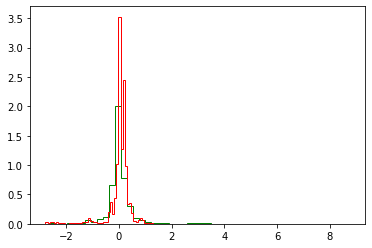

In [6]:
plt.hist(dm_.train_angles, density=True, bins=50, color='green', histtype='step')
plt.hist(dm_.test_angles, density=True, bins=50, color='red', histtype='step')
plt.show()

*Obvservation*
- The train and test steering angles do not overlap but they almost follow the same distribution
- Most of the values fall between -2 to 2 radians
- Maximum values are 0 radians

## Baseline model: mean model

In [7]:
train_angles = np.array(dm_.train_angles)
test_angles = np.array(dm_.test_angles)

In [8]:
print(f"TEST MSE (mean model): {np.mean(np.square(test_angles - train_angles.mean()))}")
print(f"TEST MSE (zero model): {np.mean(np.square(test_angles - 0))}")

TEST MSE (mean model): 0.19112687369474946
TEST MSE (zero model): 0.19089104348993743


The mean model being our baseline, has a MSE of 0.1911.
Any model we build should have a MSE of less than this to be of any use to us

## Autopilot model

In [9]:
class MinMaxNormalization(nn.Module):
    def __init__(self):
        super(MinMaxNormalization, self).__init__()
        
    def forward(self, x):
        xmin = x.min()
        xmax = x.max()
        return (x - xmin)/(xmax - xmin)

In [10]:
class Autopilot(nn.Module):
    def __init__(self):
        super(Autopilot, self).__init__()
        
        self.normalization = MinMaxNormalization()
        
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=24, 
            kernel_size=5,
            stride=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=24, 
            out_channels=36, 
            kernel_size=5,
            stride=2
        )
        self.conv3 = nn.Conv2d(
            in_channels=36, 
            out_channels=48, 
            kernel_size=5,
            stride=2
        )
        self.conv4 = nn.Conv2d(
            in_channels=48, 
            out_channels=64, 
            kernel_size=3
        )
        self.conv5 = nn.Conv2d(
            in_channels=64, 
            out_channels=64, 
            kernel_size=3
        )
        self.fc1 = nn.Linear(
            in_features=1152,
            out_features=1164
        )
        self.fc2= nn.Linear(
            in_features=1164,
            out_features=100
        )
        self.fc3= nn.Linear(
            in_features=100,
            out_features=50
        )
        self.fc4= nn.Linear(
            in_features=50,
            out_features=10
        )
        self.fc5= nn.Linear(
            in_features=10,
            out_features=1
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight)
        
    def forward(self, x):
        
        # Min-Max normalization
        x = self.normalization(x)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = torch.flatten(x, 1)
        
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = F.dropout(F.relu(self.fc3(x)))
        x = F.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        
        return x

## Lightning Module

In [19]:
class SteerLitModel(pl.LightningModule):
    def __init__(self):
        super(SteerLitModel, self).__init__()
        self.model = Autopilot()
        self.loss = nn.MSELoss()

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-4)

    def forward(self, images):
        return self.model(images)

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        labels = batch["angle"]
                
        preds = self.forward(images)
        loss = self.loss(input=preds[0], target=labels)

        self.log("train_MSE", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images = batch["image"]
        labels = batch["angle"]
        
        preds = self.forward(images)
        loss = self.loss(input=preds[0], target=labels)

        self.log("val_MSE", loss, prog_bar=True)

        return loss    

In [20]:
dm = SteerDataModule(label_path=Config.label_path)
model = SteerLitModel()

checkpoint_callback = ModelCheckpoint(
    dirpath="./models", 
    monitor="val_acc", 
    mode="max", 
    verbose=True,
    save_top_k=3,
    filename='{epoch}-{val_loss:.2f}-{val_acc:.2f}'
)

early_stop_callback = EarlyStopping(
    monitor="val_acc", 
    min_delta=0.00, 
    patience=3, 
    verbose=True, 
    mode="max"
)

trainer = pl.Trainer(
    fast_dev_run=True,
    logger=True,
#     max_epochs=Config.EPOCHS,
    accelerator="auto", 
    callbacks=[checkpoint_callback, early_stop_callback],
)

trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | Autopilot | 1.6 M 
1 | loss  | MSELoss   | 0     
------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.382     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]